# Contracts Tutor – Figure 3: Calibration of Predicted vs. Observed Win Rates

This notebook generates **Figure 3** of the Contracts Tutor paper:

> *Calibration of model-predicted win probabilities vs. observed win rates (LLM vs. Instructors). Points show the observed win rate in each decile of the predicted probability (horizontal axis uses the bin mean predicted win rate). Vertical bars are Wilson 95\% confidence intervals. The dotted line ($y=x$) indicates perfect calibration. Blue: Gemini vs. Instructor; orange: NotebookLM vs. Instructor. Predicted probabilities are derived from a logit model regressing preferences on $\Delta$-features (legal anchors, reasoning nuance, structural organization, confident tone, clarity, length, and pedagogical support). Systematic elevation of observed points above the diagonal implies that the included textual features do not fully explain the LLM advantage.*

Re-running this notebook with the same input data and the `pA_hat_logit` column will regenerate Figure 3 (`figures/observed_vs_predicted.png`).

## 1. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from typing import List, Dict, Tuple, Optional
from math import sqrt
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster, cov_cluster_2groups


## 2. Load pairwise data and parse model identifiers

In [3]:
def parse_model_id(model_id):
    """
    Parse model_id to extract the model name.
    
    Format: 
    - LLMs: model_question_version (e.g., "gemini_q1_v2")
    - Professors: prof_professorName_question_version (e.g., "prof_Smith_q1_v1")
    
    Returns:
    - model_type: 'gemini', 'nlm', or 'professor'
    - model_name: specific name (e.g., 'gemini', 'nlm', or 'Smith')
    """
    parts = model_id.split('_')
    
    if parts[0] == 'prof':
        # Professor format: prof_professorName_question_version
        return 'professor', parts[1], parts[3]  # Return professor name
    else:
        # LLM format: model_question_version
        return parts[0], parts[0], parts[2]  # Return model name (gemini or nlm)

def preprocess_data(df):
    """
    Preprocess the dataframe by extracting model information.
    """
    # Extract model types and names for both models
    df['model_a_type'], df['model_a_name'], df['version_a'] = zip(*df['model_a_id'].apply(parse_model_id))
    df['model_b_type'], df['model_b_name'], df['version_b'] = zip(*df['model_b_id'].apply(parse_model_id))
    
    # Extract question number from model_a_id (assuming format is consistent)
    df['question'] = df['model_a_id'].apply(lambda x: x.split('_')[1] if 'prof' not in x else x.split('_')[2])
    
    return df

df = pd.read_csv('pairwise_tutors_data_anonymized.csv')

df = preprocess_data(df)

df = df.copy()

## 3. Construct answer keys and pair identifiers

In [4]:
df["answer_key_a"] = df["model_a_id"]
df["answer_key_b"] = df["model_b_id"]

# Unordered pair key: sort the two answer keys so (A,B) == (B,A)
def make_pair_key(a, b):
    x, y = sorted([str(a), str(b)])
    return f"{x}||{y}"

df["pair_key"] = df.apply(lambda r: make_pair_key(r["answer_key_a"], r["answer_key_b"]), axis=1)

# Also a per-row "preferred answer id" that is order-invariant for agreement checks
df["preferred_answer_id"] = np.where(
    df["decision"].str.upper().eq("A"), df["answer_key_a"], df["answer_key_b"]
)

## 4. Feature construction and logit predictions

In [5]:
# -----------------------------
# Basic tokenization helpers
# -----------------------------
def sent_tokenize(text: str) -> List[str]:
    if not isinstance(text, str):
        return []
    # Simple rule-based split on punctuation + space
    sents = re.split(r'(?<=[.?!])\s+', text.strip())
    return [s for s in sents if s]

def word_tokenize(text: str) -> List[str]:
    if not isinstance(text, str):
        return []
    return re.findall(r"[A-Za-z][A-Za-z'-]*", text)

def n_words(text: str) -> int:
    return len(word_tokenize(text))

def per_100_words(count: float, total_words: int) -> float:
    return (100.0 * count / max(total_words, 1))

def per_sentence(count: float, n_sent: int) -> float:
    return count / max(n_sent, 1)

def safe_div(a: float, b: float) -> float:
    return a / b if b else 0.0

# -----------------------------
# Lexicons / patterns
# -----------------------------
STRUCTURE_CUES = ["issue", "rule", "analysis", "conclusion", "holding", "test", "factors", "elements", "application"]

SCAFFOLD_CUES = ["because", "for example", "for instance", "e.g.", "i.e.", "in other words", "thus", "therefore", "so", "hence"]

EXAMPLE_CUES = ["for example", "for instance", "e.g."]

ASSERTIVE_CUES = ["therefore", "thus", "clearly", "the court held", "must", "will", "establishes"]

HEDGE_CUES = ["might", "may", "could", "generally", "probably", "often", "sometimes", "likely"]

NUANCE_CUES = ["however", "although", "unless", "except", "on the other hand", "nevertheless", "nonetheless", "but", "yet"]

ENUM_CUES = [r"\(\d+\)", r"\b\d+\.", r"\bfirst\b", r"\bsecond\b", r"\bthird\b"]

CONCLUSION_CUES = ["yes", "no", "likely", "unlikely", "it depends", "under", "therefore", "thus"]

LEGAL_ANCHOR_PATTERNS = [
    r"\b[A-Z][a-zA-Z]+ v\. [A-Z][a-zA-Z]+",   # Case pattern "Name v. Name"
    r"§",                                      # Section symbol
    r"\bUCC\b",
    r"\bRestatement\b",
    r"\b\d+\s*U\.S\.\s*\d+",
    r"\bCal\.\s*Civ\.\s*Code\b",
]

def count_regex_patterns(text: str, patterns: List[str]) -> int:
    if not isinstance(text, str):
        return 0
    return sum(len(re.findall(p, text)) for p in patterns)

def count_cues(text_lower: str, cues: List[str]) -> int:
    if not isinstance(text_lower, str):
        return 0
    return sum(text_lower.count(c) for c in cues)

def any_enumeration(text: str) -> int:
    return int(any(re.search(p, text, flags=re.IGNORECASE) for p in ENUM_CUES))

# ---- Flesch Reading Ease ----
def count_syllables(word: str) -> int:
    word = word.lower()
    vowels = "aeiouy"
    word = re.sub(r'[^a-z]', '', word)
    if not word:
        return 0
    groups = re.findall(r'[aeiouy]+', word)
    syllables = len(groups)
    if word.endswith("e") and not word.endswith(("le", "ue")) and syllables > 1:
        syllables -= 1
    return max(1, syllables)

def flesch_reading_ease(text: str) -> float:
    sents = sent_tokenize(text)
    words = word_tokenize(text)
    n_sent = len(sents)
    n_w = len(words)
    n_syll = sum(count_syllables(w) for w in words)

    aws = safe_div(n_w, n_sent)       # avg words per sentence
    asw = safe_div(n_syll, n_w)       # avg syllables per word

    # Flesch Reading Ease score
    fre = 206.835 - 1.015 * aws - 84.6 * asw
    return fre

# -----------------------------
# Compute features for ONE answer
# -----------------------------
def compute_answer_features(answer_text: str,
                            question_id: Optional[str]=None) -> Dict[str, float]:
    if not isinstance(answer_text, str):
        answer_text = ""

    text = answer_text.strip()
    text_lower = text.lower()
    sents = sent_tokenize(text)
    n_sent = len(sents)
    words = word_tokenize(text)
    n_w = len(words)
    avg_words_per_sent = safe_div(n_w, n_sent)
    avg_chars_per_word = safe_div(sum(len(w) for w in words), max(n_w, 1))

    # 1) Structure
    n_struct_labels = sum(1 for cue in STRUCTURE_CUES if re.search(rf"\b{re.escape(cue)}\b", text_lower))
    feat_structure_irac_signal = 1.0 if n_struct_labels >= 2 else 0.0

    # 2) Legal anchors (normalized)
    legal_anchor_count = count_regex_patterns(text, LEGAL_ANCHOR_PATTERNS)
    feat_legal_anchors_norm = per_100_words(legal_anchor_count, n_w)

    # 3) Reasoning nuance rate
    nuance_hits = count_cues(text_lower, NUANCE_CUES)
    feat_reasoning_nuance_rate = per_sentence(nuance_hits, n_sent)

    # 4) Pedagogical scaffolding rate
    scaffold_hits = count_cues(text_lower, SCAFFOLD_CUES)
    feat_pedag_scaffold_rate = per_sentence(scaffold_hits, n_sent)

    # 5) Dialogic question rate
    q_sents = sum(1 for s in sents if "?" in s)
    feat_dialogic_question_rate = per_sentence(q_sents, n_sent)

    # 6) Tone confidence score (assertive - hedge normalized)
    assertive_hits = count_cues(text_lower, ASSERTIVE_CUES)
    hedge_hits = count_cues(text_lower, HEDGE_CUES)
    feat_tone_confidence_score = per_100_words(assertive_hits - hedge_hits, n_w)

    # 7) Clarity proxy
    feat_clarity_simple = flesch_reading_ease(text)

    # 8) Log length
    feat_length_log = float(np.log1p(n_w)) # log(1+words)

    # 9) Enumeration signal
    feat_enumeration_signal = float(any_enumeration(text))

    # 10) Early conclusion (first two sentences)
    first2 = " ".join(sents[:2]).lower() if n_sent else ""
    feat_conclusion_early = float(any(c in first2 for c in CONCLUSION_CUES))

    return {
        "feat_structure_irac_signal":        feat_structure_irac_signal,
        "feat_legal_anchors_norm":           feat_legal_anchors_norm,
        "feat_reasoning_nuance_rate":        feat_reasoning_nuance_rate,
        "feat_pedag_scaffold_rate":          feat_pedag_scaffold_rate,
        "feat_dialogic_question_rate":       feat_dialogic_question_rate,
        "feat_tone_confidence_score":        feat_tone_confidence_score,
        "feat_clarity_simple":               feat_clarity_simple,
        "feat_length_log":                   feat_length_log,
        "feat_enumeration_signal":           feat_enumeration_signal,
        "feat_conclusion_early":             feat_conclusion_early
    }

# -----------------------------
# Build answer-level table from your pairs df
# Expected columns present in df_pairs:
#   answer_key_a, answer_a_text, answer_key_b, answer_b_text, question_id, question_category
# -----------------------------
def build_answer_feature_table(df_pairs: pd.DataFrame) -> pd.DataFrame:
    A = df_pairs[["answer_key_a", "answer_a_text", "question_id", "question_category"]].rename(
        columns={"answer_key_a": "answer_key", "answer_a_text": "answer_text"}
    )
    B = df_pairs[["answer_key_b", "answer_b_text", "question_id", "question_category"]].rename(
        columns={"answer_key_b": "answer_key", "answer_b_text": "answer_text"}
    )
    ans = pd.concat([A, B], ignore_index=True)

    # keep the longest non-null text per answer_key
    ans["__len__"] = ans["answer_text"].fillna("").str.len()
    ans = ans.sort_values("__len__", ascending=False).drop_duplicates("answer_key").drop(columns="__len__")

    feats = ans.apply(
        lambda row: compute_answer_features(
            answer_text=row["answer_text"],
            question_id=row["question_id"]
        ),
        axis=1
    )
    feats_df = pd.DataFrame(list(feats.values))
    features_df = pd.concat([ans[["answer_key", "question_id", "question_category"]].reset_index(drop=True),
                             feats_df.reset_index(drop=True)], axis=1)
    return features_df

# -----------------------------
# Merge to pairs, build A−B diffs and label y
# -----------------------------
def make_pairwise_dataset(df_pairs: pd.DataFrame, features_df: pd.DataFrame):
    feat_cols = [c for c in features_df.columns if c.startswith("feat_")]

    A = features_df.rename(columns={c: f"{c}_A" for c in features_df.columns if c != "answer_key"})
    B = features_df.rename(columns={c: f"{c}_B" for c in features_df.columns if c != "answer_key"})

    dfm = (df_pairs
          .merge(A, left_on="answer_key_a", right_on="answer_key", how="left").drop(columns=["answer_key"])
          .merge(B, left_on="answer_key_b", right_on="answer_key", how="left").drop(columns=["answer_key"])
          )

    # Label: 1 if A preferred, else 0
    y = (dfm["preferred_answer_id"] == dfm["answer_key_a"]).astype(int)

    # A−B difference features
    diff_cols = []
    for f in feat_cols:
        fa, fb = f"{f}_A", f"{f}_B"
        if fa in dfm.columns and fb in dfm.columns:
            dfm[f"{f}_diff"] = dfm[fa].astype(float) - dfm[fb].astype(float)
            diff_cols.append(f"{f}_diff")
    
    # Optional: keep context columns for diagnostics (not used by the extended BT fit)
    pair_context_cols = [c for c in ["question_category", "question_id", "model_a_type", "model_b_type"] if c in dfm.columns]

    X_diff = dfm[diff_cols + pair_context_cols].copy()
    meta = dfm[["pair_key", "judge_name", "question_id", "answer_key_a", "answer_key_b"]].copy()

    return X_diff, y, diff_cols, pair_context_cols, meta

def inspect_collinearity(features_df: pd.DataFrame):
    num_cols = [c for c in features_df.columns if c.startswith("delta_")]
    corr = features_df[num_cols].corr().abs().round(2)
    print("Top correlations (>|0.70|):")
    pairs = []
    for i, c1 in enumerate(num_cols):
        for c2 in num_cols[i+1:]:
            r = corr.loc[c1, c2]
            if r >= 0.70:
                pairs.append((r, c1, c2))
    for r, c1, c2 in sorted(pairs, reverse=True):
        print(f"{c1} ~ {c2}: r={r}")

        
# -----------------------------
# Sanity check: scales of Δ features
# -----------------------------
def check_diff_scales(X_diff: pd.DataFrame, diff_cols: List[str], quantiles=(0.01, 0.99)):
    qlo, qhi = quantiles
    print("Δ feature ranges (approx):")
    rows = []
    for c in diff_cols:
        s = X_diff[c].astype(float)
        rows.append({
            "feature": c,
            "mean": float(s.mean()),
            "std": float(s.std(ddof=1)),
            "q01": float(s.quantile(qlo)),
            "q99": float(s.quantile(qhi))
        })
    print(pd.DataFrame(rows).sort_values("std", ascending=False).to_string(index=False))

In [11]:
def add_combo_features(features_df: pd.DataFrame) -> pd.DataFrame:
    out = features_df.copy()

    # Structural combo: IRAC + enumeration + early conclusion (0..3)
    out["feat_structural_combo"] = (
        out["feat_structure_irac_signal"].astype(float)
        + out["feat_enumeration_signal"].astype(float)
        + out["feat_conclusion_early"].astype(float)
    )

    # Pedagogical combo: dialogic questions per sentence + scaffold cues per sentence
    out["feat_pedagogical_combo"] = (
        out["feat_dialogic_question_rate"].astype(float)
        + out["feat_pedag_scaffold_rate"].astype(float)
    )

    # (Optional) Binary indicator for any structural cue present
    # out["feat_structural_any"] = (out["feat_structural_combo"] > 0).astype(float)

    return out

In [6]:
def preprocess_all_features(df: pd.DataFrame, feat_prefix: str = "feat_",
                            lower: float = 0.01, upper: float = 0.99) -> pd.DataFrame:
    '''
    winsorize plus z score standardization
    '''
    out = df.copy()
    cols = [c for c in out.columns if c.startswith(feat_prefix)]
    for c in cols:
        s = out[c].astype(float)
        q_low = s.quantile(lower)
        q_high = s.quantile(upper)
        # winsorize
        sw = s.clip(lower=q_low, upper=q_high)
        # z-score standardize
        mean, std = sw.mean(), sw.std(ddof=0)
        if std <= 0:
            print('std', std)
        std = std if std > 0 else 1.0
        out[c] = (sw - mean) / std
    return out

In [7]:
def create_difference_features(pair_df: pd.DataFrame,
                               feat_df: pd.DataFrame,
                               feat_prefix: str = "feat_",
                               keep_side_features: bool = False) -> pd.DataFrame:
    """
    Merge per-answer features onto pairwise rows and compute Δfeatures = feat_a - feat_b.
    
    Assumptions:
      - pair_df has columns: answer_key_a, answer_key_b, question_id
      - feat_df has one row per (answer_key, question_id) with columns starting with feat_prefix
      - already preprocessed (winsorized/standardized) feat_* columns
    
    Params
    ------
    keep_side_features : if True, keep *_a and *_b columns alongside deltas
    
    Returns
    -------
    pair_with_deltas : pair_df with new columns delta_<feat>
    """
    # Identify feature columns
    feat_cols = [c for c in feat_df.columns if c.startswith(feat_prefix)]
    key_cols = ["answer_key", "question_id"]

    # Ensure uniqueness in the features table on (answer_key, question_id)
    feat_df_unique = (
        feat_df[key_cols + feat_cols]
        .sort_values(key_cols)
        .drop_duplicates(subset=key_cols, keep="last")
    )

    # Prepare 'A' side merge
    feat_a = feat_df_unique.rename(columns={c: f"{c}_a" for c in feat_cols})
    pair_aug = pair_df.merge(
        feat_a.rename(columns={"answer_key": "answer_key_a"}),
        how="left",
        on=["answer_key_a", "question_id"],
        validate="m:1"
    )

    # Prepare 'B' side merge
    feat_b = feat_df_unique.rename(columns={c: f"{c}_b" for c in feat_cols})
    pair_aug = pair_aug.merge(
        feat_b.rename(columns={"answer_key": "answer_key_b"}),
        how="left",
        on=["answer_key_b", "question_id"],
        validate="m:1"
    )

    # Compute deltas: A minus B
    for c in feat_cols:
        pair_aug[f"delta_{c}"] = pair_aug[f"{c}_a"] - pair_aug[f"{c}_b"]

    # Optional: drop side features to keep only deltas
    if not keep_side_features:
        drop_cols = [f"{c}_a" for c in feat_cols] + [f"{c}_b" for c in feat_cols]
        pair_aug = pair_aug.drop(columns=drop_cols)

    return pair_aug

In [8]:
# 1) Build answer-level features from pairs
features_df = build_answer_feature_table(df)

In [9]:
inspect_collinearity(features_df)

Top correlations (>|0.70|):


In [12]:
# 2) Add combos
features_df = add_combo_features(features_df)

In [13]:
features_df.drop(columns=['feat_enumeration_signal', 'feat_structure_irac_signal', 'feat_conclusion_early', 'feat_dialogic_question_rate', 'feat_pedag_scaffold_rate'], inplace=True)

In [14]:
inspect_collinearity(features_df)

Top correlations (>|0.70|):


In [15]:
check_diff_scales(features_df, features_df.columns[3:])

Δ feature ranges (approx):
                   feature      mean       std       q01       q99
       feat_clarity_simple 41.588833 17.654416 -0.869456 81.395151
   feat_legal_anchors_norm  0.656572  2.090887  0.000000  4.400907
feat_tone_confidence_score -0.374920  1.365546 -4.255319  2.752137
     feat_structural_combo  0.945687  0.711798  0.000000  2.880000
           feat_length_log  4.455486  0.609840  2.137702  5.585958
    feat_pedagogical_combo  0.443647  0.463930  0.000000  2.000000
feat_reasoning_nuance_rate  0.117728  0.198660  0.000000  0.750000


In [17]:
# 3) Winsorize + standardize (answer-level)
features_df_std = preprocess_all_features(features_df, feat_prefix="feat_")

In [18]:
check_diff_scales(features_df_std, features_df_std.columns[3:])

Δ feature ranges (approx):
                   feature          mean      std       q01      q99
     feat_structural_combo  6.810314e-17 1.001601 -1.336681 2.591164
    feat_pedagogical_combo -7.661603e-17 1.001601 -1.003611 3.586874
       feat_clarity_simple -7.945366e-17 1.001601 -2.561794 2.396862
           feat_length_log  9.080418e-17 1.001601 -3.998979 1.969194
   feat_legal_anchors_norm  0.000000e+00 1.001601 -0.585554 4.012206
feat_reasoning_nuance_rate -5.675261e-17 1.001601 -0.679988 3.856202
feat_tone_confidence_score -1.135052e-17 1.001601 -3.023537 2.421635


In [19]:
inspect_collinearity(features_df_std)

Top correlations (>|0.70|):


In [20]:
pair_with_deltas = create_difference_features(df, features_df_std, feat_prefix="feat_", keep_side_features=False)

In [21]:
inspect_collinearity(pair_with_deltas)

Top correlations (>|0.70|):


In [22]:
DELTA_FEATURES = [
    'delta_feat_legal_anchors_norm',
    'delta_feat_reasoning_nuance_rate',
    'delta_feat_tone_confidence_score',
    'delta_feat_clarity_simple',
    'delta_feat_length_log',
    'delta_feat_structural_combo',
    'delta_feat_pedagogical_combo',
]

# --- Outcome as before (A wins = 1) ---
def make_outcome(df: pd.DataFrame) -> pd.Series:
    y = pd.Series(np.nan, index=df.index, dtype=float)
    has_ids = df['preferred_answer_id'].notna() & df['answer_key_a'].notna() & df['answer_key_b'].notna()
    y.loc[has_ids & (df['preferred_answer_id'] == df['answer_key_a'])] = 1.0
    y.loc[has_ids & (df['preferred_answer_id'] == df['answer_key_b'])] = 0.0
    if 'decision' in df.columns:
        undec = y.isna()
        dec = df.loc[undec, 'decision'].astype(str)
        y.loc[undec & dec.str.upper().eq('A')] = 1.0
        y.loc[undec & dec.str.upper().eq('B')] = 0.0
        y.loc[undec & df.loc[undec, 'decision'].eq(1)] = 1.0
        y.loc[undec & df.loc[undec, 'decision'].eq(0)] = 0.0
        y.loc[undec & dec.str.lower().eq('answer_a')] = 1.0
        y.loc[undec & dec.str.lower().eq('answer_b')] = 0.0
    return y.astype(float)

# --- Build working frame & fit logit ---
df0 = pair_with_deltas.copy()
y = make_outcome(df0)
keep = y.notna()
df = df0.loc[keep].copy()
y = y.loc[keep]

X = df[DELTA_FEATURES].astype(float)
Xc = sm.add_constant(X, has_constant='add')

logit = sm.Logit(y, Xc, missing='drop').fit(disp=False, maxiter=200)
df['pA_hat_logit'] = logit.predict(Xc)

## 5. Focal matchups and calibration bins and plot calibration curve (Figure 3)

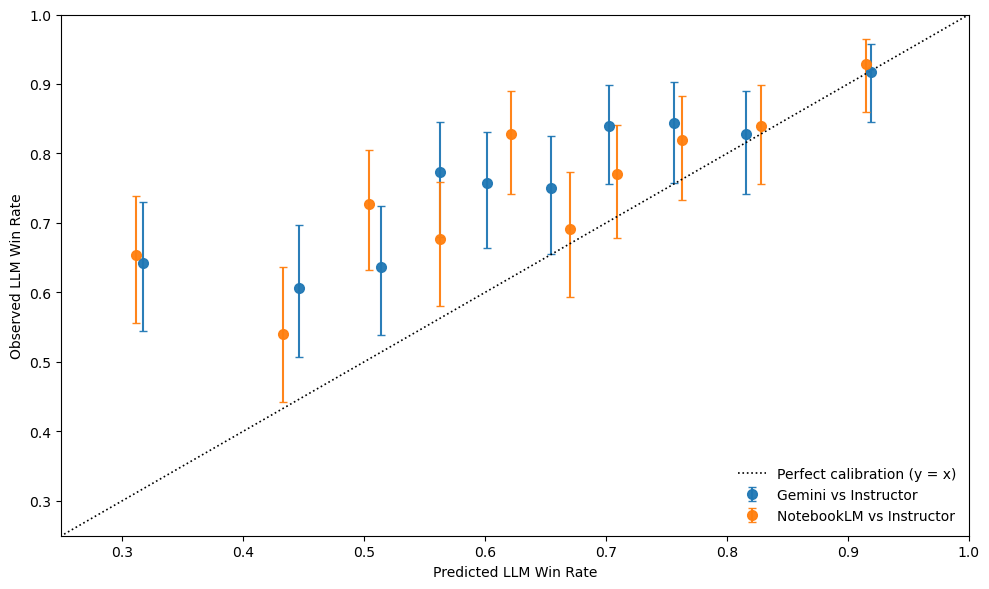

In [23]:
# =========================================
# Keep only (Gemini vs Instructor) and (NLM vs Instructor)
# and compute focal-model predictions/outcomes per row
# =========================================

def is_gemini(name: str) -> bool:
    return 'gemini' in str(name).lower()

def is_prof(model_type: str, name: str) -> bool:
    return ('prof' in str(model_type).lower()) or str(name).lower().startswith('prof_')

def is_nlm(name: str, model_type: str) -> bool:
    s = f"{name} {model_type}".lower()
    return 'nlm' in s  # adjust to your exact label if needed

# Side flags
df['A_is_gemini'] = df['model_a_name'].apply(is_gemini)
df['B_is_gemini'] = df['model_b_name'].apply(is_gemini)
df['A_is_prof']   = [is_prof(t, n) for t, n in zip(df['model_a_type'], df['model_a_name'])]
df['B_is_prof']   = [is_prof(t, n) for t, n in zip(df['model_b_type'], df['model_b_name'])]
df['A_is_nlm']    = [is_nlm(n, t) for n, t in zip(df['model_a_name'], df['model_a_type'])]
df['B_is_nlm']    = [is_nlm(n, t) for n, t in zip(df['model_b_name'], df['model_b_type'])]

# Predicted prob that side A wins from the logit you already fit:
# df['pA_hat_logit'] must already exist
assert 'pA_hat_logit' in df.columns, "Run the logit prediction step first."

# Build a unified "focal" view:
# - If matchup is Gemini vs Instructor -> focal = Gemini
# - If matchup is NLM vs Instructor    -> focal = NLM
def row_matchup_and_preds(row):
    # Identify the matchup type we care about (else return None)
    if (row.A_is_gemini and row.B_is_prof) or (row.B_is_gemini and row.A_is_prof):
        matchup = 'Gemini vs Instructor'
        focal_A = row.A_is_gemini  # True if focal (Gemini) is on side A
    elif (row.A_is_nlm and row.B_is_prof) or (row.B_is_nlm and row.A_is_prof):
        matchup = 'NotebookLM vs Instructor'
        focal_A = row.A_is_nlm
    else:
        return pd.Series({'matchup': 'other', 'p_hat_focal': np.nan, 'focal_win': np.nan})

    # Predicted prob focal wins (convert from P(A wins))
    pA = row.pA_hat_logit
    p_hat_focal = pA if focal_A else (1.0 - pA)

    # Realized outcome y = 1 if A wins (must exist in current scope)
    # We stashed it earlier as 'y' aligned to df's index. Pull it by index:
    y_i = y.loc[row.name]
    focal_win = (y_i == 1) if focal_A else (y_i == 0)
    return pd.Series({'matchup': matchup, 'p_hat_focal': float(p_hat_focal), 'focal_win': int(focal_win)})

# Build row-wise matchup + predictions
tmp = df.apply(row_matchup_and_preds, axis=1)
# Ensure we don't carry stale columns that would duplicate names
for c in ['matchup', 'p_hat_focal', 'focal_win']:
    if c in df.columns:
        df = df.drop(columns=[c])

# Overwrite into a fresh copy (avoids duplicate column names)
df_cal = df.copy()
df_cal[['matchup', 'p_hat_focal', 'focal_win']] = tmp[['matchup','p_hat_focal','focal_win']].to_numpy()

# Now this is a boolean Series, not a DataFrame
mask = df_cal['matchup'].isin(['Gemini vs Instructor','NotebookLM vs Instructor'])
df_cal = df_cal.loc[mask].copy()

# sanity check: no duplicate column names
assert not df_cal.columns.duplicated().any()

# ----------------------------
# Decile binning within each matchup using focal predictions
# ----------------------------
def decile_bin(s, q=10):
    return pd.qcut(s, q=q, labels=False, duplicates='drop') + 1

df_cal['decile'] = df_cal.groupby('matchup')['p_hat_focal'].transform(decile_bin)

# Wilson interval
from math import sqrt
def wilson_ci(k, n, z=1.96):
    if n == 0:
        return (np.nan, np.nan)
    phat = k / n
    denom = 1 + z**2/n
    center = (phat + z**2/(2*n)) / denom
    half = z * sqrt((phat*(1-phat) + z**2/(4*n)) / n) / denom
    return (center - half, center + half)

# Aggregate per decile
g = df_cal.groupby(['matchup','decile'], as_index=False).agg(
    n=('focal_win','size'),
    obs_rate=('focal_win','mean'),
    pred_mean=('p_hat_focal','mean')
)
cis = g.apply(lambda r: pd.Series(wilson_ci(int(round(r['obs_rate']*r['n'])), int(r['n']))), axis=1)
g[['obs_ci_low','obs_ci_high']] = cis
g['excess'] = g['obs_rate'] - g['pred_mean']
bin_stats = g.sort_values(['matchup','decile'])

# ----------------------------
# Plot: x = bin mean predicted prob, y = observed, with y=x diagonal
# ----------------------------
import numpy as np
def plot_prob_x_with_diagonal(bin_df, title='Calibration by bin mean predicted prob (focal vs Instructor)'):
    fig, ax = plt.subplots(figsize=(10, 6))
    for mtype, sub in bin_df.groupby('matchup'):
        sub = sub.sort_values('pred_mean')
        ax.errorbar(
            sub['pred_mean'], sub['obs_rate'],
            yerr=[sub['obs_rate']-sub['obs_ci_low'], sub['obs_ci_high']-sub['obs_rate']],
            fmt='o', ms=7, capsize=3, linestyle='none',
            label=mtype, alpha=0.95
        )
    xs = np.linspace(0, 1, 200)
    ax.plot(xs, xs, 'k:', lw=1.2, label='Perfect calibration (y = x)')
    #ax.axhline(0.5, color='red', linestyle='--', lw=1, alpha=0.7, label='50% baseline')
    ax.set_xlim(0.25, 1)
    ax.set_ylim(0.25, 1)
    ax.set_xlabel('Predicted LLM Win Rate')
    ax.set_ylabel('Observed LLM Win Rate')
    #ax.set_title(title)
    ax.legend(frameon=False, loc='lower right')
    plt.tight_layout()
    plt.show()

plot_prob_x_with_diagonal(bin_stats)

# (Optional) nice per-decile table
bin_table = (bin_stats
    .assign(
        ci_str=lambda d: d['obs_ci_low'].round(3).astype(str) + ' — ' + d['obs_ci_high'].round(3).astype(str)
    )
    .loc[:, ['matchup','decile','n','pred_mean','obs_rate','ci_str','excess']]
    .sort_values(['matchup','decile'])
)
#print("\nPer-decile summary:")
#print(bin_table.to_string(index=False))